<a href="https://colab.research.google.com/github/dgb1106/fake-news-detection/blob/main/fake_news_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load the train set and data preparing

In [2]:
df = pd.read_csv('/content/drive/MyDrive/fake_news_detection_dataset/train.csv')
df.head()

,title,text,subject,date,label
0,SocGen says no wrongdoing in handling of Natio...,PARIS (Reuters) - French bank Societe Generale...,worldnews,"November 22, 2017",1
1,North Carolina governor concedes election to D...,"WINSTON-SALEM, N.C. (Reuters) - North Carolina...",politicsNews,"December 5, 2016",1
2,TRUMP FEVER! W. VA Dem Senator Says He Won’t V...,Civil political discourse took a beating in We...,left-news,"Aug 7, 2017",0
3,New York vows to sue Trump over immigrant chil...,(Reuters) - New York and Washington state on M...,politicsNews,"September 4, 2017",1
4,Orlando killer expressed support for multiple ...,"ORLANDO, Fla. (Reuters) - Orlando nightclub ki...",politicsNews,"June 12, 2016",1


## Data preprocessing

In [3]:
# drop unnecessary columns (subjects and data may have little impact on the output)
df.drop(['subject', 'date'], axis=1, inplace=True)
df.head()

,title,text,label
0,SocGen says no wrongdoing in handling of Natio...,PARIS (Reuters) - French bank Societe Generale...,1
1,North Carolina governor concedes election to D...,"WINSTON-SALEM, N.C. (Reuters) - North Carolina...",1
2,TRUMP FEVER! W. VA Dem Senator Says He Won’t V...,Civil political discourse took a beating in We...,0
3,New York vows to sue Trump over immigrant chil...,(Reuters) - New York and Washington state on M...,1
4,Orlando killer expressed support for multiple ...,"ORLANDO, Fla. (Reuters) - Orlando nightclub ki...",1


In [4]:
# combine the title and the text
df['combined_text'] = 'title: ' + df['title'] + ' content: ' + df['text']
df.head()

,title,text,label,combined_text
0,SocGen says no wrongdoing in handling of Natio...,PARIS (Reuters) - French bank Societe Generale...,1,title: SocGen says no wrongdoing in handling o...
1,North Carolina governor concedes election to D...,"WINSTON-SALEM, N.C. (Reuters) - North Carolina...",1,title: North Carolina governor concedes electi...
2,TRUMP FEVER! W. VA Dem Senator Says He Won’t V...,Civil political discourse took a beating in We...,0,title: TRUMP FEVER! W. VA Dem Senator Says He ...
3,New York vows to sue Trump over immigrant chil...,(Reuters) - New York and Washington state on M...,1,title: New York vows to sue Trump over immigra...
4,Orlando killer expressed support for multiple ...,"ORLANDO, Fla. (Reuters) - Orlando nightclub ki...",1,title: Orlando killer expressed support for mu...


In [5]:
import re
import string
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

lemmatizer = WordNetLemmatizer()

def clean_text(text):
  # Lowercase
  text = text.lower()
  # Remove HTML tags
  text = re.sub(r'<.*?>', ' ', text)
  # Remove URLs
  text = re.sub(r'http\S+|www\S+|https\S+', ' ', text)
  # Remove punctuation
  text = text.translate(str.maketrans('', '', string.punctuation))
  # Removes [], () and the content inside it from `text`
  text = re.sub('\[,*?\]', '', text)
  text = re.sub(r'\([^)]*\)', '', text)
  # Removes characters that are not digits or letters and replace it with a space
  text = re.sub('\\W', ' ', text)
  # Removes all new line characters `\n` from the text
  text = re.sub('\n', '', text)
  # tokenize and remove stopwords
  words = text.split()
  words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
  return ' '.join(words)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
df['cleaned_text'] = df['combined_text'].apply(clean_text)
df.head()

,title,text,label,combined_text,cleaned_text
0,SocGen says no wrongdoing in handling of Natio...,PARIS (Reuters) - French bank Societe Generale...,1,title: SocGen says no wrongdoing in handling o...,title socgen say wrongdoing handling national ...
1,North Carolina governor concedes election to D...,"WINSTON-SALEM, N.C. (Reuters) - North Carolina...",1,title: North Carolina governor concedes electi...,title north carolina governor concedes electio...
2,TRUMP FEVER! W. VA Dem Senator Says He Won’t V...,Civil political discourse took a beating in We...,0,title: TRUMP FEVER! W. VA Dem Senator Says He ...,title trump fever w va dem senator say vote pa...
3,New York vows to sue Trump over immigrant chil...,(Reuters) - New York and Washington state on M...,1,title: New York vows to sue Trump over immigra...,title new york vow sue trump immigrant child p...
4,Orlando killer expressed support for multiple ...,"ORLANDO, Fla. (Reuters) - Orlando nightclub ki...",1,title: Orlando killer expressed support for mu...,title orlando killer expressed support multipl...


### Pipeline construction

In [7]:
X_train = df['cleaned_text']
y_train = df['label']

In [8]:
from os import pipe
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('xgb', XGBClassifier(
        tree_method='gpu_hist',
        predictor='gpu_predictor',
        use_label_encoder=False,
        eval_metric='logloss'
    ))
])

In [9]:
param_dist = {
    'xgb__n_estimators': [100, 200, 300],
    'xgb__learning_rate': [0.01, 0.05, 0.1],
    'xgb__max_depth': [4, 6, 8],
    'xgb__subsample': [0.7, 0.9, 1.0],
    'xgb__colsample_bytree': [0.7, 0.9, 1.0]
}

In [10]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=10,
    cv=cv,
    scoring='f1',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

search.fit(X_train, y_train)

print("Best F1 (CV):", search.best_score_)
print("Best hyper-parameters:\n", search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:03:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:03:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best F1 (CV): 0.901067789698072
Best hyper-parameters:
 {'xgb__subsample': 1.0, 'xgb__n_estimators': 300, 'xgb__max_depth': 6, 'xgb__learning_rate': 0.1, 'xgb__colsample_bytree': 0.9}


# Testing and evaluation

In [20]:
df_test = pd.read_csv("/content/drive/MyDrive/fake_news_detection_dataset/test.csv")
df_test.head()

,title,text,subject,date,label
0,Trump names Don McGahn as White House Counsel ...,"WASHINGTON/WEST PALM BEACH, Fla. (Reuters) - U...",politicsNews,"November 25, 2016",1
1,"Senate Judiciary Committee seeks Comey memos, ...",WASHINGTON (Reuters) - The Senate Judiciary Co...,politicsNews,"May 17, 2017",1
2,South Carolina Governor Nikki Haley Says We’v...,We ve never passed racist laws in this country...,News,"January 14, 2016",0
3,China's internet regulator denounces its forme...,BEIJING (Reuters) - China s internet regulator...,worldnews,"November 23, 2017",1
4,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",1


In [21]:
# drop unnecessary columns (subjects and data may have little impact on the output)
df_test.drop(['subject', 'date'], axis=1, inplace=True)
df_test.head()

,title,text,label
0,Trump names Don McGahn as White House Counsel ...,"WASHINGTON/WEST PALM BEACH, Fla. (Reuters) - U...",1
1,"Senate Judiciary Committee seeks Comey memos, ...",WASHINGTON (Reuters) - The Senate Judiciary Co...,1
2,South Carolina Governor Nikki Haley Says We’v...,We ve never passed racist laws in this country...,0
3,China's internet regulator denounces its forme...,BEIJING (Reuters) - China s internet regulator...,1
4,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,1


In [22]:
# combine the title and the text
df_test['combined_text'] = 'title: ' + df_test['title'] + ' content: ' + df_test['text']
df_test.head()

,title,text,label,combined_text
0,Trump names Don McGahn as White House Counsel ...,"WASHINGTON/WEST PALM BEACH, Fla. (Reuters) - U...",1,title: Trump names Don McGahn as White House C...
1,"Senate Judiciary Committee seeks Comey memos, ...",WASHINGTON (Reuters) - The Senate Judiciary Co...,1,title: Senate Judiciary Committee seeks Comey ...
2,South Carolina Governor Nikki Haley Says We’v...,We ve never passed racist laws in this country...,0,title: South Carolina Governor Nikki Haley Sa...
3,China's internet regulator denounces its forme...,BEIJING (Reuters) - China s internet regulator...,1,title: China's internet regulator denounces it...
4,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,1,title: Minsk cultural hub becomes haven from a...


In [23]:
df_test['cleaned_text'] = df_test['combined_text'].apply(clean_text)
df_test.head()

,title,text,label,combined_text,cleaned_text
0,Trump names Don McGahn as White House Counsel ...,"WASHINGTON/WEST PALM BEACH, Fla. (Reuters) - U...",1,title: Trump names Don McGahn as White House C...,title trump name mcgahn white house counsel tr...
1,"Senate Judiciary Committee seeks Comey memos, ...",WASHINGTON (Reuters) - The Senate Judiciary Co...,1,title: Senate Judiciary Committee seeks Comey ...,title senate judiciary committee seek comey me...
2,South Carolina Governor Nikki Haley Says We’v...,We ve never passed racist laws in this country...,0,title: South Carolina Governor Nikki Haley Sa...,title south carolina governor nikki haley say ...
3,China's internet regulator denounces its forme...,BEIJING (Reuters) - China s internet regulator...,1,title: China's internet regulator denounces it...,title china internet regulator denounces forme...
4,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,1,title: Minsk cultural hub becomes haven from a...,title minsk cultural hub becomes authority con...


In [25]:
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)
import matplotlib.pyplot as plt

# df_test = pd.read_csv("/content/drive/MyDrive/fake_news_detection_dataset/cleaned_test.csv")
X_test_raw = df_test['cleaned_text']
y_test     = df_test['label']

best_pipeline = search.best_estimator_

In [26]:
X_test_vec = best_pipeline.named_steps['tfidf'].transform(X_test_raw)
y_pred     = best_pipeline.named_steps['xgb'].predict(X_test_vec)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:12:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:12:13] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [27]:
acc   = accuracy_score(y_test, y_pred)
prec  = precision_score(y_test, y_pred)
rec   = recall_score(y_test, y_pred)
f1    = f1_score(y_test, y_pred)
cm    = confusion_matrix(y_test, y_pred)

print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")

Accuracy : 0.9937
Precision: 0.9893
Recall   : 0.9974
F1-score : 0.9934


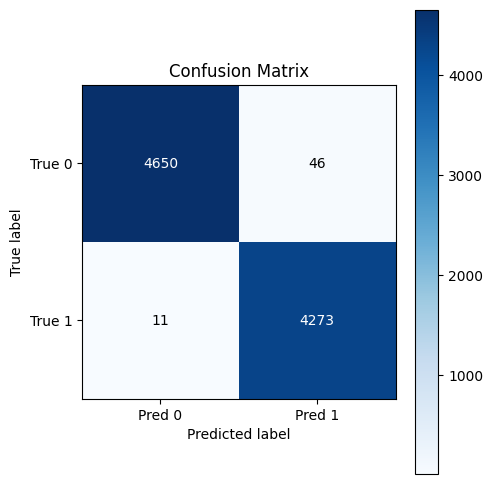

In [28]:
plt.figure(figsize=(5,5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks([0,1], ['Pred 0','Pred 1'])
plt.yticks([0,1], ['True 0','True 1'])
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()